# Introducere


Scopul invatarii automate
- crearea unei legaturi intre date (date de intrare si date de iesire, date cunoscute si date necunoascute)

Cum?
- cu ajutorul unui program1 menit sa antreneze un alt program2 (numit model de predictie) care va procesa informatiile propriu-zise (numite date de antrenament)
- dupa antrenare, programul2 (modelul) va prelua date si va furniza rezultate (predictii)

Invatarea automata
- supervizata - atunci cand datele de antrenament sunt etichetate (= date de intrare cunoscute, date de iesire cunoscute)
- nesupervizata - atunci cand datele de antrenament nu sunt etichetate (= date de intrare cunoscute, date de iesire necunoscute, dar exista unele informatii despre acestea)

Pasi importanti in dezvoltarea unui proiect de invatare automata
1. definirea problemei in terminologia invatarii automate
2. colectarea si pregatirea datelor
3. antrenarea unui model de predictie
4. utilizarea modelului de predictie 

# Exemplificare probleme de regresie

## Prerequisites



In [4]:
#@title run the code below to import the necessary dependencies 

import csv
import matplotlib.pyplot as plt 
import os
import io
import requests
import pandas as pd

from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn import linear_model

  
def loadData(fileName, featureNames, outputVariabName):
    data = []
    dataNames = []
    csv_reader = csv.reader(fileName, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            dataNames = row
        else:
            data.append(row)
        line_count += 1
    inputs = []
    for i in range(len(data)):
        crtExample = []
        for feature in featureNames:
            selectedVariable = dataNames.index(feature)
            crtExample.append(data[i][selectedVariable])
        inputs.append(crtExample)
        
    selectedOutput = dataNames.index(outputVariabName)
    outputs = []
    for i in range(len(data)):
        outputs.append(data[i][selectedOutput])
    
    return inputs, outputs

def fromStringToNumericData(values):
    if isinstance(values[0], list):
        aux = []
        for i in range(len(values)):
            line = []
            for j in range(len(values[i])):
                line.append(float(values[i][j]))
            aux.append(line)
        return aux
    else:
        aux = []
        for i in range(len(values)):
            aux.append(float(values[i]))
        return aux

def getFeature(data, pos):
    values = []
    for i in range(len(data)):
        values.append(data[i][pos])
    return values

def plotData(inputData, outputData, inputNames, outputName):
    # a single feature
    if len(inputData[0]) == 1: 
        featureValues = [inputData[i][0] for i in range(len(inputData))]        
        fig = plt.plot(featureValues, outputData, 'ro') 
        plt.xlabel(inputNames[0])
        plt.ylabel(outputName)
        plt.title(outputName + ' for different ' + inputNames[0])
        plt.show()
    else:
        # two features
        if len(inputData[0]) == 2:
            featureValues1 = [inputData[i][0] for i in range(len(inputData))] 
            featureValues2 = [inputData[i][1] for i in range(len(inputData))]   
            from mpl_toolkits import mplot3d
            ax = plt.axes(projection = '3d')
            fig = plt.scatter(featureValues1, featureValues2, outputData, c = 'r', marker = 'o')
            ax.set_xlabel(inputNames[0])
            ax.set_ylabel(inputNames[1])
            ax.set_zlabel(outputName)
            plt.title(outputName + ' for different ' + inputNames[0] + ' and ' + inputNames[1])
            plt.show()
        else: 
            print('two many dimensions to be plotted...')
            
def plotHistograms(inputs, outputs):
    noFeatures = len(inputs[0])
    fig, ax = plt.subplots(1, noFeatures + 1,  figsize=(4 * (noFeatures + 1), 4))
    for i in range(noFeatures):
        crtFeatureValues = getFeature(inputs, i)
        ax[i].hist(crtFeatureValues, 10, color = 'r')
        ax[i].title.set_text('histogram of ' + featureNames[i])
    ax[noFeatures].hist(outputs, 10, color = 'g')
    ax[noFeatures].title.set_text('histogram of ' + outputName)

    plt.show()

def visualiseRegressor(regressor):
    modelString = 'the learnt model: f(x) = ' + str(regressor.intercept_) 
    for i in range(noFeatures):
        modelString = modelString + ' + ' + str(regressor.coef_[i]) + ' * x^' + str(i + 1)
    print(modelString)

def plotRegressor(regressor, inputs, outputs):
    # prepare some synthetic data (inputs are random, while the outputs are computed by the learnt model)
    noOfPoints = 500
    xref = []
    xvalues = getFeature(inputs, 0)
    val = min(xvalues)
    step = (max(xvalues) - min(xvalues)) / noOfPoints
    for i in range(1, noOfPoints):
        xref.append(val)
        val += step
    yref = [regressor.intercept_ + regressor.coef_[0] * el for el in xref] 

    plt.plot(inputs, outputs, 'ro', label = 'training data')  #train data are plotted by red and circle sign
    plt.plot(xref, yref, 'b-', label = 'learnt model')                  #model is plotted by a blue line
    plt.title('train data and the learnt model')
    plt.xlabel('temp')
    plt.ylabel('cnt')
    plt.legend()
    plt.show()

def plotClassificationData(inputs, outputs, featureNames):
    noExamples = len(inputs)
    labels = set(outputs)
    noData = len(inputs)
    for crtLabel in labels:
        x = [inputs[i][0] for i in range(noExamples) if outputs[i] == crtLabel ]
        y = [inputs[i][1] for i in range(noExamples) if outputs[i] == crtLabel ]
        plt.scatter(x, y, label = crtLabel)
    plt.xlabel(featureNames[0])
    plt.ylabel(featureNames[1])
    plt.legend()
    plt.show()  

def plotPredictions(feature1, feature2, realOutputs, computedOutputs, title, featureNames, labels):
    noData = len(feature1)
    for crtLabel in labels:
        x = [feature1[i] for i in range(noData) if realOutputs[i] == crtLabel and computedOutputs[i] == crtLabel ]
        y = [feature2[i] for i in range(noData) if realOutputs[i] == crtLabel and computedOutputs[i] == crtLabel]
        plt.scatter(x, y, label = crtLabel + ' (correct)')
    for crtLabel in labels:
        x = [feature1[i] for i in range(noData) if realOutputs[i] == crtLabel and computedOutputs[i] != crtLabel ]
        y = [feature2[i] for i in range(noData) if realOutputs[i] == crtLabel and computedOutputs[i] != crtLabel]
        plt.scatter(x, y, label = crtLabel + ' (incorrect)')
    plt.xlabel(featureNames[0])
    plt.ylabel(featureNames[1])
    plt.legend()
    plt.title(title)
    plt.show()

def countExamples(outputs):
    labels = list(set(outputs)).sort()
    distribution = {}
    for label in outputs:
        if label in distribution.keys():
            distribution[label] += 1
        else:
            distribution[label] = 1
    return distribution


## Scenariul 1: predictia gradului de bunastare sociala pe baza PIB-ului 


Proces:
- Se pleaca de la un set de date format din date economico-sociale diverse culese pentru mai multe tari
- Se stabilesc variabile independente (PIB) si dependente (gradul de bunastare sociala)
- Se aplica algoritmul de invatare pe setul de date de antrenament
- Se realizeaza predictii ale gradului de bunastare sociala pentru noi valori ale PIB-ului

In [5]:
#@title run the code below to inspect the raw data

url = 'http://www.cs.ubbcluj.ro/~lauras/test/docs/docum/world-happiness-report-2017.csv'
r = requests.get(url)
filePath = io.StringIO(r.text)

dataCrt = pd.read_csv(filePath)
dataCrt.head()

,Country,Happiness.Rank,Happiness.Score,Whisker.high,Whisker.low,Economy..GDP.per.Capita.,Family,Health..Life.Expectancy.,Freedom,Generosity,Trust..Government.Corruption.,Dystopia.Residual
0,Norway,1,7.537,7.594445,7.479556,1.616463,1.533524,0.796667,0.635423,0.362012,0.315964,2.277027
1,Denmark,2,7.522,7.581728,7.462272,1.482383,1.551122,0.792566,0.626007,0.355280,0.400770,2.313707
2,Iceland,3,7.504,7.622030,7.385970,1.480633,1.610574,0.833552,0.627163,0.475540,0.153527,2.322715
3,Switzerland,4,7.494,7.561772,7.426227,1.564980,1.516912,0.858131,0.620071,0.290549,0.367007,2.276716
4,Finland,5,7.469,7.527542,7.410458,1.443572,1.540247,0.809158,0.617951,0.245483,0.382612,2.430182


### Specificarea problemei 

- date de intrare: PIB
- date de iesire: gradul de bunastare sociala

In [6]:
#@title run the code below for setting the input data and the output data
 
url = 'http://www.cs.ubbcluj.ro/~lauras/test/docs/docum/world-happiness-report-2017.csv'
r = requests.get(url)
filePath = io.StringIO(r.text)

# first use case: a model for predicting the happiness based on the GDP
noFeatures = 1
featureNames = ['Economy..GDP.per.Capita.']
outputName = 'Happiness.Score'



### Incarcarea si auditarea datelor

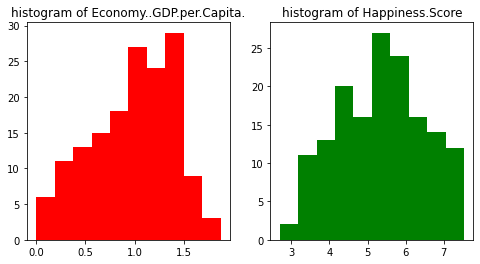

In [7]:
#@title run the code below for loading and auditing the data

# load and audit the dataset
inputs, outputs = loadData(filePath, featureNames, outputName)
inputs = fromStringToNumericData(inputs)
outputs = fromStringToNumericData(outputs)

# see how the data looks (plot the histograms associated to input data - temperature - and output data - no bikes)
plotHistograms(inputs, outputs)

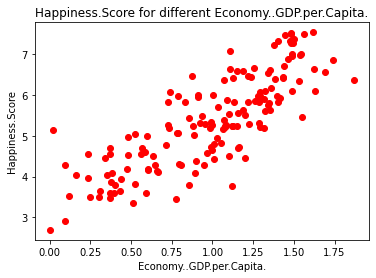

In [8]:
#@title run the code below to check the relationship betwwen input and output data

# check the relationship (to check that a linear relationship exists between the dependent variable (y = no bikes) and the independent variable (x = temp).)
plotData(inputs, outputs, featureNames, outputName)

### Antrenarea unui model de predictie

the learnt model: f(x) = 3.2032126826861878 + 2.1841849463496823 * x^1


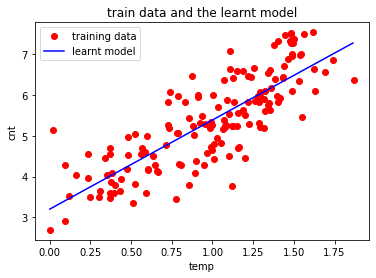

prediction training error:   0.43215056729547646


In [9]:
#@title run the code below for training the regressor; the training error will be printed

# learning step: init and train a linear regression model y = f(happiness) = w0 + w1 * GDP

# model initialisation
regressor = linear_model.LinearRegression()

# training the model by using the training inputs and known training outputs
regressor.fit(inputs, outputs)

# visualise the trained model 
visualiseRegressor(regressor)

# plot the learnt model
if (noFeatures == 1):
    plotRegressor(regressor, inputs, outputs)
else:
    print('to many dimensions...')

computedOutputs = regressor.predict(inputs)
error = mean_squared_error(outputs, computedOutputs)
print('prediction training error:  ', error)

### Utilizarea unui model de predictie

In [10]:
#@title run the code below for predicting the happiness score for some particular GDP values

# use case: a model for predicting the happiness based on the GDP
testData = [[1.1], [1.5], [1.3]]

print('for a GDP value of ', testData[0], ' the predicted happiness scor is: ', regressor.predict(testData)[0])
print('for a GDP value of ', testData[1], ' the predicted happiness scor is: ', regressor.predict(testData)[1])
print('for a GDP value of ', testData[2], ' the predicted happiness scor is: ', regressor.predict(testData)[2])

for a GDP value of  [1.1]  the predicted happiness scor is:  5.605816123670838
for a GDP value of  [1.5]  the predicted happiness scor is:  6.479490102210711
for a GDP value of  [1.3]  the predicted happiness scor is:  6.042653112940775


## Scenariul 2: predictia numarului de biciclete inchiriate pe baza unor factori diversi precum temperatura, viteza vantului, ziua din saptamana, etc.

Proces:
- Se pleaca de la un set de date format din date diverse despre numarul de biciclete inchiriate
- Se stabilesc variabile independente (temperatura, viteza vantului, ziua din saptamana) si dependente (nr de biciclete)
- Se aplica algoritmul de invatare pe setul de date de antrenament
- Se realizeaza predictii ale numarul de biciclete pe baza unuia sau unora dintre factorii de influenta

In [11]:
#@title run the code below to inspect the raw data

url = 'http://www.cs.ubbcluj.ro/~lauras/test/docs/docum/hour.csv'
r = requests.get(url)
filePath = io.StringIO(r.text)

dataCrt = pd.read_csv(filePath)
dataCrt.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


### Specificarea problemei 

- date de intrare: viteza vantului
- date de iesire: nr de biciclete

In [12]:
#@title run the code below for setting the input data and the output data

# first use case: a model for predicting the no of bikes based on the wind speed
noFeatures = 1
featureNames = ['windspeed']
outputName = 'cnt'


### Incarcarea si auditarea datelor

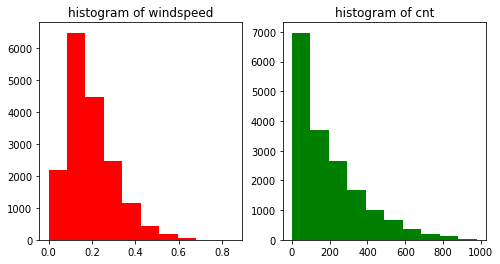

In [13]:
#@title run the code below for loading and auditing the data

url = 'http://www.cs.ubbcluj.ro/~lauras/test/docs/docum/hour.csv'
r = requests.get(url)
filePath = io.StringIO(r.text)

# load and audit the dataset
inputs, outputs = loadData(filePath, featureNames, outputName)
inputs = fromStringToNumericData(inputs)
outputs = fromStringToNumericData(outputs)

# see how the data looks (plot the histograms associated to input data - temperature - and output data - no bikes)
plotHistograms(inputs, outputs)

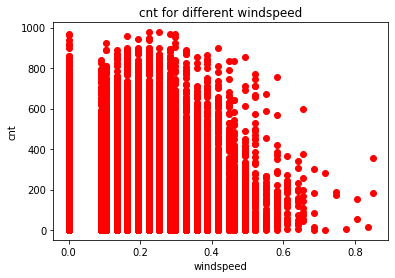

In [14]:
#@title run the code below to check the relationship betwwen input and output data

# check the relationship (to check that a linear relationship exists between the dependent variable (y = no bikes) and the independent variable (x = temp).)
plotData(inputs, outputs, featureNames, outputName)

### Antrenarea unui model de predictie

the learnt model: f(x) = 163.18533236292936 + 138.23296243514469 * x^1


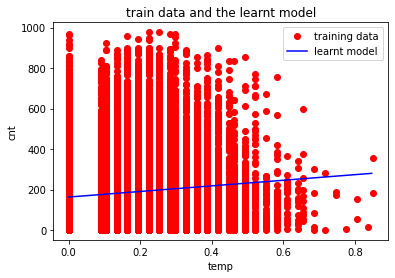

prediction training error:   32613.58717115028


In [15]:
#@title run the code below for training the regressor; the training error will be printed

# learning step: init and train a linear regression model y = f(noBikes) = w0 + w1 * windspeed

# model initialisation
regressor2 = linear_model.LinearRegression()

# training the model by using the training inputs and known training outputs
regressor2.fit(inputs, outputs)

# visualise the trained model 
visualiseRegressor(regressor2)

# plot the learnt model
if (noFeatures == 1):
    plotRegressor(regressor2, inputs, outputs)
else:
    print('to many dimensions...')

computedOutputs = regressor2.predict(inputs)
error = mean_squared_error(outputs, computedOutputs)
print('prediction training error:  ', error)

### Utilizarea unui model de predictie

In [16]:
#@title run the code below for predicting the happiness score for some particular windspeed values

# predict the number of bikes for a set of new 3 windspeed
testData = [[0.3284], [0.2985], [0.3015]]

print('for a wind speed of ', testData[0], ' the predicted no bikes is: ', regressor.predict(testData)[0])
print('for a wind speed of ', testData[1], ' the predicted no bikes is: ', regressor.predict(testData)[1])
print('for a wind speed of ', testData[2], ' the predicted no bikes is: ', regressor.predict(testData)[2])

for a wind speed of  [0.3284]  the predicted no bikes is:  3.9204990190674236
for a wind speed of  [0.2985]  the predicted no bikes is:  3.855191889171568
for a wind speed of  [0.3015]  the predicted no bikes is:  3.861744444010617


## Scenariul 3: predictia numarului de biciclete inchiriate pe baza unor factori diversi precum temperatura, viteza vantului, ziua din saptamana, etc.

Proces:
- Se pleaca de la un set de date format din date diverse despre numarul de biciclete inchiriate
- Se stabilesc variabile independente (temperatura, viteza vantului, ziua din saptamana) si dependente (nr de biciclete)
- Se aplica algoritmul de invatare pe setul de date de antrenament
- Se realizeaza predictii ale numarul de biciclete pe baza unuia sau unora dintre factorii de influenta

In [17]:
#@title run the code below to inspect the raw data

url = 'http://www.cs.ubbcluj.ro/~lauras/test/docs/docum/hour.csv'
r = requests.get(url)
filePath = io.StringIO(r.text)

dataCrt = pd.read_csv(filePath)
dataCrt.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


### Specificarea problemei 

- date de intrare: viteza vantului, temperatura
- date de iesire: nr de biciclete

In [18]:
#@title run the code below for setting the input data and the output data

# second use case: a model for predicting the no of bikes based on the temperature and the wind speed
noFeatures = 2
featureNames = ['atemp', 'windspeed']
outputName = 'cnt'

url = 'http://www.cs.ubbcluj.ro/~lauras/test/docs/docum/hour.csv'
r = requests.get(url)
filePath = io.StringIO(r.text)

### Incarcarea si auditarea datelor

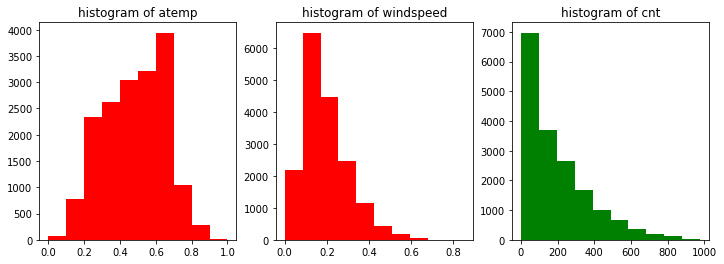

In [19]:
#@title run the code below for loading and auditing the data

# load and audit the dataset
inputs, outputs = loadData(filePath, featureNames, outputName)
inputs = fromStringToNumericData(inputs)
outputs = fromStringToNumericData(outputs)

# see how the data looks (plot the histograms associated to input data - temperature - and output data - no bikes)
plotHistograms(inputs, outputs)

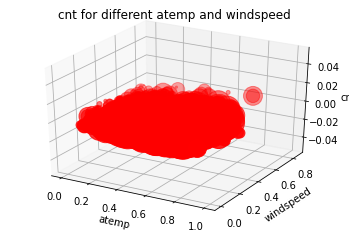

In [20]:
#@title run the code below to check the relationship between input and output data

# check the relationship (to check that a linear relationship exists between the dependent variable (y = no bikes) and the independent variable (x = temp).)
plotData(inputs, outputs, featureNames, outputName)

### Antrenarea unui model de predictie

In [21]:
#@title run the code below for training the regressor; the training error will be printed

# learning step: init and train a linear regression model y = f(noBikes) = w0 + w1 * windspeed

# model initialisation
regressor3 = linear_model.LinearRegression()

# training the model by using the training inputs and known training outputs
regressor3.fit(inputs, outputs)

# visualise the trained model 
visualiseRegressor(regressor3)

# plot the learnt model
if (noFeatures == 1):
    plotRegressor(regressor3, inputs, outputs)
else:
    print('to many dimensions...')

computedOutputs = regressor3.predict(inputs)
error = mean_squared_error(outputs, computedOutputs)
print('prediction training error:  ', error)

the learnt model: f(x) = -49.042662583697506 + 430.9892740313349 * x^1 + 175.97162319354254 * x^2
to many dimensions...
prediction training error:   27149.50482688288


### Utilizarea unui model de predictie

In [22]:
#@title run the code below for predicting the happiness score for some particular temperature and windspeed values

# predict the number of bikes for a set of new 3 tempeatures and 3 windspeeds 
testData = [[0.33, 0.3284], [0.46, 0.2985], [0.42, 0.3015]]

print('for temp and windspeed values of ', testData[0], ' the predicted no bikes is: ;', regressor3.predict(testData)[0])
print('for temp and windspeed values of ', testData[1], ' the predicted no bikes is: ;', regressor3.predict(testData)[1])
print('for temp and windspeed values of ', testData[2], ' the predicted no bikes is: ;', regressor3.predict(testData)[2])

for temp and windspeed values of  [0.33, 0.3284]  the predicted no bikes is: ; 150.9728789034024
for temp and windspeed values of  [0.46, 0.2985]  the predicted no bikes is: ; 201.73993299398902
for temp and windspeed values of  [0.42, 0.3015]  the predicted no bikes is: ; 185.0282769023162


# Exemplificare probleme de clasificare 

Se doreste identificarea tipului de tesut mamar pe baza unor masuratori bioelectrice (e.g. I0  - impedanta la frecventa 0, MaxIP - spectrul maxim, Area - Aria de sub spectru, etc.)




## Scenariul 1: predictia tipului de tesut (normal sau patologic) pe baza caracteristicilor MaxIP si Area

Proces:
- Se pleaca de la un set de date format din masuratorile bioelectrice asociate unor probe de tesut mamar  si etichetele asociate lor
- se aleg anumite caracteristici dintre aceste masuratori (drept variabile independente) precum MaxIP si Area
- Se aplica algoritmul de invatare pe setul de antrenament
- Se realizeaza predictii pentru noi mesaje (= se eticheteaza noi mesaje)

In [23]:
#@title run the code below to inspect the raw data

url = 'http://www.cs.ubbcluj.ro/~lauras/test/docs/docum/breastCancerBin.csv'
r = requests.get(url)
filePath = io.StringIO(r.text)

dataCrt = pd.read_csv(filePath)
dataCrt.head()

,Case#,Class,I0,PA500,HFS,DA,Area,A/DA,MaxIP,DR,P
0,1,pathological,524.794072,0.187448,0.032114,228.800228,6843.598481,29.910803,60.204880,220.737212,556.828334
1,2,pathological,330.000000,0.226893,0.265290,121.154201,3163.239472,26.109202,69.717361,99.084964,400.225776
2,3,pathological,551.879287,0.232478,0.063530,264.804935,11888.391830,44.894903,77.793297,253.785300,656.769449
3,4,pathological,380.000000,0.240855,0.286234,137.640111,5402.171180,39.248524,88.758446,105.198568,493.701813
4,5,pathological,362.831266,0.200713,0.244346,124.912559,3290.462446,26.342127,69.389389,103.866552,424.796503


### Specificarea problemei
- stabilirea caracteristicilor (date de intrare) - MaxIP si Area
- stabilirea valorilor care trebuie prezise (date de iesire) - tipul de tesut (normal sau patologic)

In [24]:
#@title run the code below for setting the input data and the output data
# first use case: predict the type of tissue (connective, adipose, glandular, carcinoma, fibro-adenoma, mastopathy) based on MaxIP and Area
noFeatures = 2
featureNames = ['MaxIP', 'Area']
outputName = 'Class'

### Incarcarea si auditarea datelor

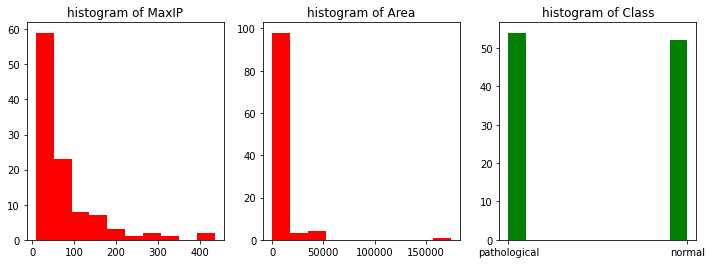

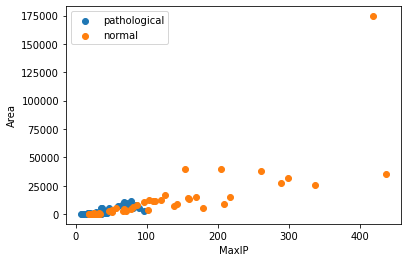

In [25]:
#@title run the code below for loading and auditing the data

url = 'http://www.cs.ubbcluj.ro/~lauras/test/docs/docum/breastCancerBin.csv'
r = requests.get(url)
filePath = io.StringIO(r.text)


inputs, outputs = loadData(filePath, featureNames, outputName)
inputs = fromStringToNumericData(inputs)

# audit the data
plotHistograms(inputs, outputs)
if (noFeatures == 2):
    plotClassificationData(inputs, outputs, featureNames)

### Antrenarea unui model de predictie

In [26]:
#@title run the code below for training the classifier; the training error will be printed
classifier1 = linear_model.LogisticRegression()
classifier1.fit(inputs, outputs)
computedOutputs = classifier1.predict(inputs)
error = 1 - accuracy_score(outputs, computedOutputs)
print("classification training error: ", error)

classification training error:  0.30188679245283023


### Utilizarea unui model de predictie

In [27]:
#@title run the code below from preparing sone testing data

# normal, pathological, normal
testData = [[59.5, 280.5], [61, 3039.5], [60, 305]]

computed labels:  ['normal' 'normal' 'normal']


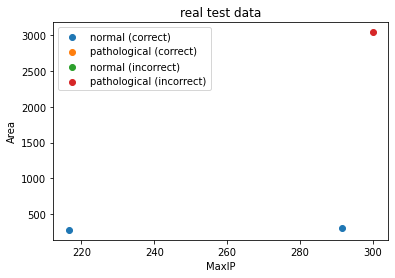

In [28]:
#@title run the code below for predicting the tissue type for previous prepared data

predictions = classifier1.predict(testData)
print('computed labels: ', predictions)

if (noFeatures == 2):
    plotPredictions([216.5, 300, 291.5], [280.5, 3039.5, 305], ['normal', 'pathological', 'normal'], predictions, "real test data", featureNames, ['normal', 'pathological'])

## Scenariul 2: predictia tipului de tesut (normal sau patologic) pe baza caracteristicilor I0 si Area


Proces:
- Se pleaca de la un set de date format din masuratorile bioelectrice asociate unor probe de tesut mamar  si etichetele asociate lor
- se aleg anumite caracteristici dintre aceste masuratori (drept variabile independente) precum IO si Area
- Se aplica algoritmul de invatare pe setul de antrenament
- Se realizeaza predictii pentru noi mesaje (= se eticheteaza noi mesaje)

In [29]:
#@title run the code below to inspect the raw data

url = 'http://www.cs.ubbcluj.ro/~lauras/test/docs/docum/breastCancerBin.csv'
r = requests.get(url)
filePath = io.StringIO(r.text)

dataCrt = pd.read_csv(filePath)
dataCrt.head()

,Case#,Class,I0,PA500,HFS,DA,Area,A/DA,MaxIP,DR,P
0,1,pathological,524.794072,0.187448,0.032114,228.800228,6843.598481,29.910803,60.204880,220.737212,556.828334
1,2,pathological,330.000000,0.226893,0.265290,121.154201,3163.239472,26.109202,69.717361,99.084964,400.225776
2,3,pathological,551.879287,0.232478,0.063530,264.804935,11888.391830,44.894903,77.793297,253.785300,656.769449
3,4,pathological,380.000000,0.240855,0.286234,137.640111,5402.171180,39.248524,88.758446,105.198568,493.701813
4,5,pathological,362.831266,0.200713,0.244346,124.912559,3290.462446,26.342127,69.389389,103.866552,424.796503


### Specificarea problemei
- stabilirea caracteristicilor (date de intrare) - I0 si Area
- stabilirea valorilor care trebuie prezise (date de iesire) - Class

In [30]:
#@title run the code below for setting the input data and the output data
# second use case: predict the type of tissue (connective, adipose, glandular, carcinoma, fibro-adenoma, mastopathy) based on I0 and Area
noFeatures = 2
featureNames = ['I0', 'Area']
outputName = 'Class'

### Incarcarea si auditarea datelor

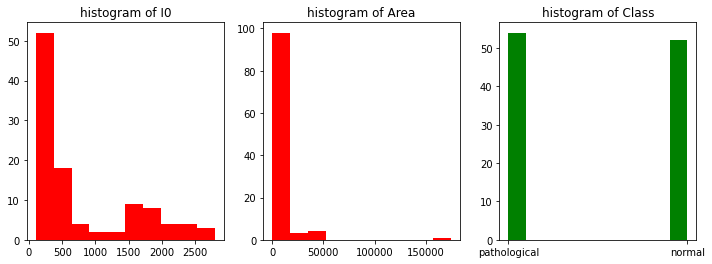

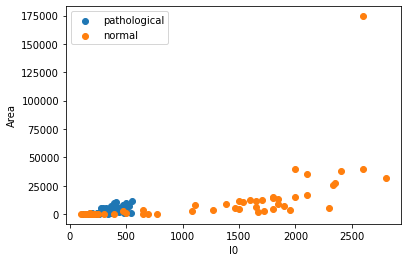

In [31]:
#@title run the code below for loading and auditing the data

url = 'http://www.cs.ubbcluj.ro/~lauras/test/docs/docum/breastCancerBin.csv'
r = requests.get(url)
filePath = io.StringIO(r.text)

inputs, outputs = loadData(filePath, featureNames, outputName)
inputs = fromStringToNumericData(inputs)

# audit the data
plotHistograms(inputs, outputs)
if (noFeatures == 2):
    plotClassificationData(inputs, outputs, featureNames)

### Antrenarea unui model de predictie

In [32]:
#@title run the code below for training the classifier; the training error will be printed

classifier2 = linear_model.LogisticRegression()
classifier2.fit(inputs, outputs)
computedOutputs = classifier2.predict(inputs)
error = 1 - accuracy_score(outputs, computedOutputs)
print("classification training error: ", error)


classification training error:  0.15094339622641506


### Utilizarea unui model de predictie

In [33]:
#@title run the code below from preparing sone testing data

# realLabels= [normal, pathological, normal]
testData = [[216.5, 280.5], [300, 3039.5], [291.5, 305]]



computed labels:  ['pathological' 'pathological' 'pathological']


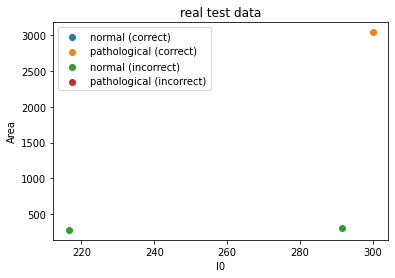

In [34]:
#@title run the code below for predicting the tissue type for previous prepared data

predictions = classifier2.predict(testData)
print('computed labels: ', predictions)

if (noFeatures == 2):
    plotPredictions([216.5, 300, 291.5], [280.5, 3039.5, 305], ['normal', 'pathological', 'normal'], predictions, "real test data", featureNames, ['normal', 'pathological'])
    

## Scenariul 3: predictia tipului de tesut (normal sau patologic, dar de 3 tipuri) pe baza caracteristicilor I0 si Area


Proces:
- Se pleaca de la un set de date format din masuratorile bioelectrice asociate unor probe de tesut mamar  si etichetele asociate lor
- se aleg anumite caracteristici dintre aceste masuratori (drept variabile independente) precum IO si Area
- Se aplica algoritmul de invatare pe setul de antrenament
- Se realizeaza predictii pentru noi mesaje (= se eticheteaza noi mesaje)

In [35]:
#@title run the code below to inspect the raw data

url = 'http://www.cs.ubbcluj.ro/~lauras/test/docs/docum/breastCancer4classes.csv'
r = requests.get(url)
filePath = io.StringIO(r.text)

dataCrt = pd.read_csv(filePath)
dataCrt[18:55]

,Case#,Class,I0,PA500,HFS,DA,Area,A/DA,MaxIP,DR,P
18,19,car,325.000000,0.224624,0.286932,229.215863,5705.332090,24.890651,35.602715,227.264794,462.703007
19,20,car,294.474846,0.206647,0.467748,194.871035,5541.256126,28.435504,36.765797,191.804890,445.513299
20,21,car,500.000000,0.192684,0.194779,144.688578,3055.012963,21.114403,96.563370,107.751103,542.897089
21,22,fad,211.000000,0.053931,0.094248,30.753443,151.984578,4.942034,14.268374,27.243124,217.130704
22,23,fad,196.856714,0.020071,0.090757,28.593126,82.058889,2.869882,7.968783,27.661516,200.749336
23,24,fad,245.000000,0.189019,0.081681,62.902955,1235.983356,19.649051,42.152016,46.690355,292.376238
24,25,fad,352.656447,0.121999,0.090757,68.527846,1066.157846,15.558024,43.691925,52.792817,382.733187
25,26,fad,243.293976,0.039968,0.067021,68.544778,383.928453,5.601134,9.991348,67.816656,263.640761
26,27,fad,259.885145,0.070686,0.006981,58.243807,465.087265,7.985180,17.506838,56.340241,267.517446
27,28,fad,250.000000,0.068068,-0.015359,57.172431,652.901349,11.419863,17.776981,55.791270,278.308615


### Specificarea problemei
- stabilirea caracteristicilor (date de intrare) - I0 si Area
- stabilirea valorilor care trebuie prezise (date de iesire) - Class (car(carcinoma), fad (fibro-adenoma), mas (mastopathy), normal)

In [36]:
#@title run the code below to see the possible labels

print(set(dataCrt['Class']))

{'fad', 'car', 'normal', 'mas'}


In [37]:
#@title run the code below for setting the input data and the output data

# third use case: predict the type of tissue (normal, carcinoma, fibro-adenoma, mastopathy) based on I0 and Area
noFeatures = 2
featureNames = ['I0', 'Area']
outputName = 'Class'

### Incarcarea si auditarea datelor

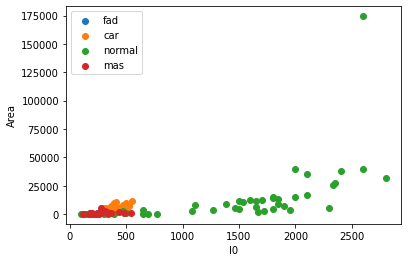

In [38]:
#@title run the code below for loading and auditing the data

url = 'http://www.cs.ubbcluj.ro/~lauras/test/docs/docum/breastCancer4classes.csv'
r = requests.get(url)
filePath = io.StringIO(r.text)

# second use case: predict the type of tissue (normal, carcinoma, fibro-adenoma, mastopathy) based on I0 and Area

inputs, outputs = loadData(filePath, featureNames, outputName)
inputs = fromStringToNumericData(inputs)

# audit the data
if (noFeatures == 2):
    plotClassificationData(inputs, outputs, featureNames)

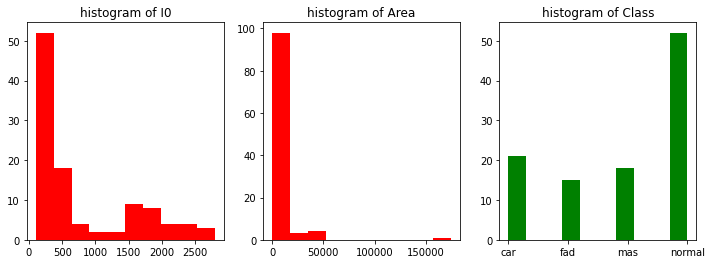

no of exampels:  106  distributed as follows:  {'car': 21, 'fad': 15, 'mas': 18, 'normal': 52}


In [39]:
#@title run the code below for a better description of the data

# Cate exemple sunt din fiecare clasa (normal, carcinoma, fibro-adenoma, mastopathy)?
plotHistograms(inputs, outputs)
print('no of exampels: ', len(inputs), ' distributed as follows: ', countExamples(outputs))

### Antrenarea unui model de predictie

In [40]:
#@title run the code below for training the classifier; the training error will be printed

classifier3 = linear_model.LogisticRegression()
classifier3.fit(inputs, outputs)
computedOutputs = classifier3.predict(inputs)
error = 1 - accuracy_score(outputs, computedOutputs)
print("classification training error: ", error)


classification training error:  0.4339622641509434


### Utilizarea unui model de predictie

In [41]:
#@title run the code below from preparing sone (artificial) testing data

# realLabels= [normal, pathological, normal]
testData = [[59.5, 280.5], [61, 3039.5], [60, 305]]

In [42]:
#@title run the code below for predicting the tissue type for previous prepared data

predictions = classifier3.predict(testData)
print('computed labels: ', predictions)

computed labels:  ['mas' 'car' 'mas']


## Scenariul 4 - recunoasterea emotilor in imagini


Proces:
- Se pleaca de la un set de date format din imagini cu fete umane
- Se extrag anumite caracteristici din aceste imagini
- Se aplica algoritmul de invatare pe setul de antrenament
- Se realizeaza predictii pentru noi imagini (= se eticheteaza noi fete cu emotiile corespunzatoare)

### Specificarea problemei

- date de intrare: imagini cu fete
- date de iesire: emotiile asociate fetelor

In [43]:
#@title run the code below for setting the prerequisites 

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import requests
import io

from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

from keras import models
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.utils import to_categorical


def prepare_data(data):
    """ Prepare data for modeling 
        input: data frame with labels und pixel data
        output: image and label array """
    
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, ' pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label

def plot_examples(label=0):
    fig, axs = plt.subplots(1, 5, figsize=(25, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(5):
        idx = data[data['emotion']==label].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        
def plot_all_emotions():
    fig, axs = plt.subplots(1, 7, figsize=(30, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(7):
        idx = data[data['emotion']==i].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        
def plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, image_number):
    """ Function to plot the image and compare the prediction results with the label """
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    
    bar_label = emotions.values()
    
    axs[0].imshow(test_image_array[image_number], 'gray')
    axs[0].set_title(emotions[test_image_label[image_number]])
    
    axs[1].bar(bar_label, pred_test_labels[image_number], color='orange', alpha=0.7)
    axs[1].grid()
    
    plt.show()
    
def plot_compare_distributions(array1, array2, title1='', title2=''):
    df_array1 = pd.DataFrame()
    df_array2 = pd.DataFrame()
    df_array1['emotion'] = array1.argmax(axis=1)
    df_array2['emotion'] = array2.argmax(axis=1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    x = emotions.values()
    
    y = df_array1['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[0].bar(x, y.sort_index(), color='orange')
    axs[0].set_title(title1)
    axs[0].grid()
    
    y = df_array2['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[1].bar(x, y.sort_index())
    axs[1].set_title(title2)
    axs[1].grid()
    
    plt.show()

### Incarcarea si auditarea datelor

In [44]:
#@title run the code below for loading and auditing the data (please be patinet during the laoding)

url = 'http://www.cs.ubbcluj.ro/~lauras/test/docs/docum/icml_face_data.csv'
r = requests.get(url)
filePath = io.StringIO(r.text)

data = pd.read_csv(filePath)
data.head()


,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


- descrierea datelor

In [45]:
#@title run the code bellow for a short data description 
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

data[' Usage'].value_counts()




Training       28709
PublicTest      3589
PrivateTest     3589
Name:  Usage, dtype: int64

- pregatirea datelor pentru invatare

In [46]:
#@title run the code bellow for data preparation

# Define training, validation and test data:
train_image_array, train_image_label = prepare_data(data[data[' Usage']=='Training'])
val_image_array, val_image_label = prepare_data(data[data[' Usage']=='PrivateTest'])
test_image_array, test_image_label = prepare_data(data[data[' Usage']=='PublicTest'])

#reshape the images
train_images = train_image_array.reshape((train_image_array.shape[0], 48, 48, 1))
train_images = train_images.astype('float32')/255
val_images = val_image_array.reshape((val_image_array.shape[0], 48, 48, 1))
val_images = val_images.astype('float32')/255
test_images = test_image_array.reshape((test_image_array.shape[0], 48, 48, 1))
test_images = test_images.astype('float32')/255

# encoding target values
train_labels = to_categorical(train_image_label)
val_labels = to_categorical(val_image_label)
test_labels = to_categorical(test_image_label)


- cateva exemple

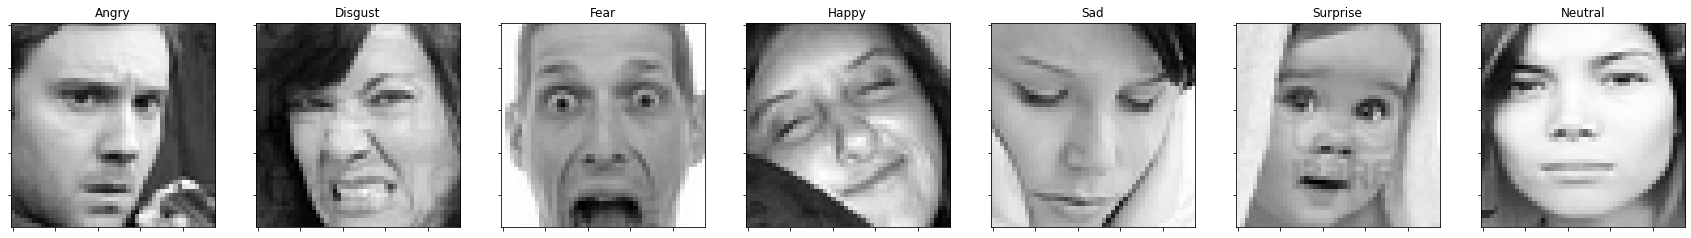

In [47]:
#@title run the code bellow for plotting some faces 

plot_all_emotions()

- distributia datelor (pe setul de antrenare si validare)

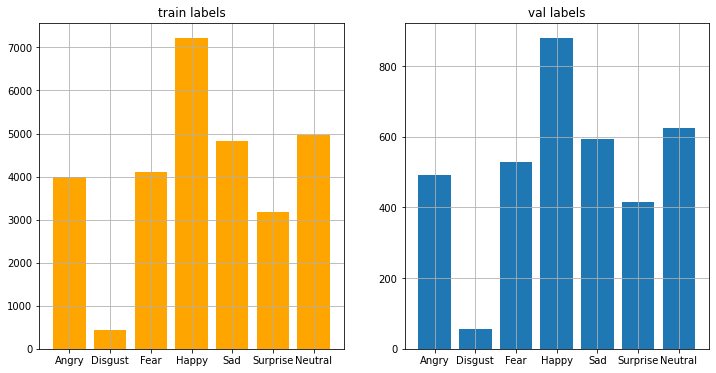

In [48]:
#@title run the code bellow for plotting the data distribution

plot_compare_distributions(train_labels, val_labels, title1='train labels', title2='val labels')

### Antrenarea unui model de predictie

- pregatirea algoritmului pentru antrenare

In [49]:
#@title run the code bellow for preparing the ML algorithm

class_weight = dict(zip(range(0, 7), (((data[data[' Usage']=='Training']['emotion'].value_counts()).sort_index())/len(data[data[' Usage']=='Training']['emotion'])).tolist()))

model = models.Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(7, activation='softmax'))
model.compile(optimizer=Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                2

- antrenarea algoritmului

In [50]:
#@title run the code bellow for traing (please be patient!!!)
history = model.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    class_weight = class_weight,
                    epochs=12,
                    batch_size=64)

Epoch 1/12
449/449 [==============================] - 74s 163ms/step - loss: 0.2836 - accuracy: 0.2717 - val_loss: 1.5434 - val_accuracy: 0.4182
Epoch 2/12
449/449 [==============================] - 73s 164ms/step - loss: 0.2304 - accuracy: 0.4285 - val_loss: 1.4559 - val_accuracy: 0.4494
Epoch 3/12
449/449 [==============================] - 75s 166ms/step - loss: 0.2082 - accuracy: 0.4846 - val_loss: 1.3879 - val_accuracy: 0.4778
Epoch 4/12
449/449 [==============================] - 74s 165ms/step - loss: 0.1948 - accuracy: 0.5108 - val_loss: 1.2988 - val_accuracy: 0.5079
Epoch 5/12
449/449 [==============================] - 74s 164ms/step - loss: 0.1832 - accuracy: 0.5489 - val_loss: 1.2650 - val_accuracy: 0.5261
Epoch 6/12
449/449 [==============================] - 74s 164ms/step - loss: 0.1721 - accuracy: 0.5758 - val_loss: 1.2842 - val_accuracy: 0.5177
Epoch 7/12
449/449 [==============================] - 73s 163ms/step - loss: 0.1621 - accuracy: 0.5972 - val_loss: 1.2781 - val_ac

### Utilizarea modelului de predictie pentru a eticheta alte imagini

In [51]:
#@title run the code bellow for predicting the emotions of new faces/images

pred_test_labels = model.predict(test_images)

test_loss, test_acc = model.evaluate(test_images, test_labels)
print('test caccuracy:', test_acc)

113/113 [==============================] - 3s 23ms/step - loss: 1.3634 - accuracy: 0.5436
test caccuracy: 0.5436054468154907


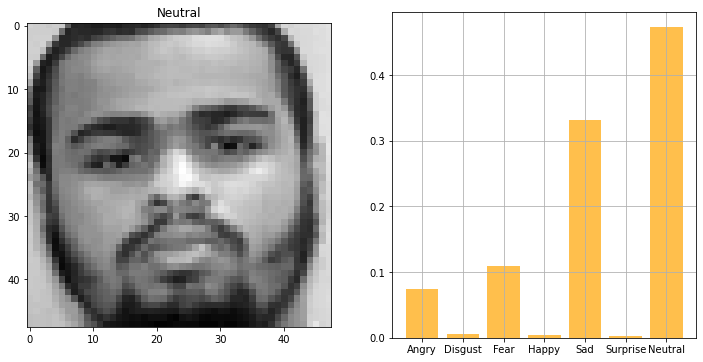

In [52]:
#@title run the code below to see one of the the predictions

plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 106)

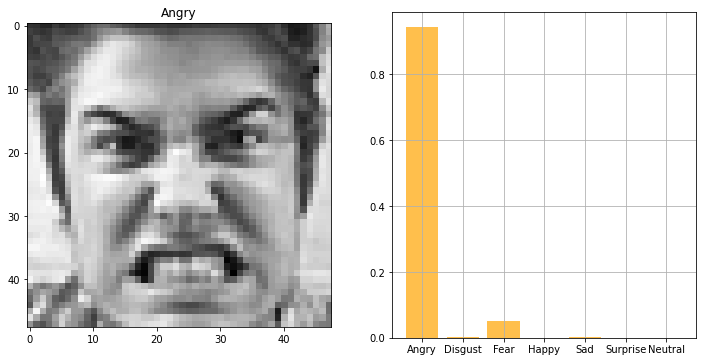

In [53]:
#@title run the code below to see another one of the the predictions

plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 40)

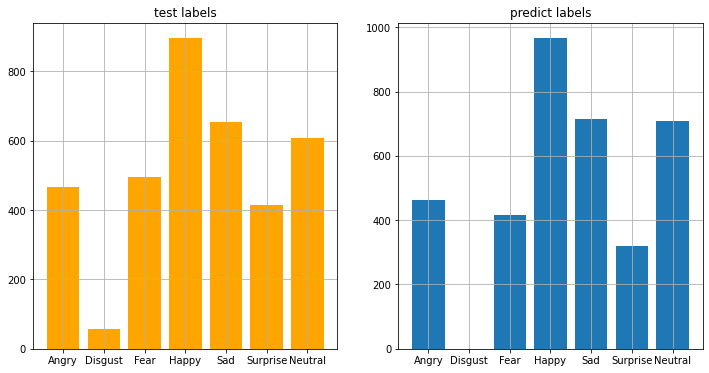

In [54]:
#@title run the code below to compare the true emotions by the predicted emotions

plot_compare_distributions(test_labels, pred_test_labels, title1='test labels', title2='predict labels')

## Scenariul 5 Separarea emailurilor in doua categorii (spam si ham)

Grupare mesaje - se doreste clasificarea unor mesaje in doua categorii (spam si ham). Pentru fiecare mesaj se cunoaste textul aferent lui.

Proces:
- Se pleaca de la un set de date format din textul mesajelor precum cel din fisierul spam.csv
- Se extrag anumite caracteristici din textul mesajelor folosind diferite reprezentari precum: Bag of Words, TF-IDF sau Word2Vec
- Se aplica algoritmul de invatare pe setul de antrenament
- Se realizeaza predictii pentru noi mesaje (= se eticheteaza noi mesaje)


### Specificarea problemei

- date de intrare: mesaje (emailuri in format text)
- date de iesire: tipul mesajelor (spam sau ham)

### Incarcarea si auditarea datelor

In [61]:
#@title run the code below for loading and auditing the data (please be patinet during the laoding)

url = 'http://www.cs.ubbcluj.ro/~lauras/test/docs/docum/spam.csv'
r = requests.get(url)
filePath = io.StringIO(r.text)

data = []
csv_reader = csv.reader(filePath, delimiter=',')
line_count = 0
for row in csv_reader:
    if line_count == 0:
        dataNames = row
    else:
        data.append(row)
    line_count += 1

inputs = [data[i][0] for i in range(len(data))]
outputs = [data[i][1] for i in range(len(data))]
labelNames = list(set(outputs))


- cateva exemple

In [62]:
#@title run the code bellow to see some examples

print('Message: [', inputs[0], '] is a', labelNames[0])
print('Message: [', inputs[1], '] is a', labelNames[1])

Message: [ Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat... ] is a ham
Message: [ Ok lar... Joking wif u oni... ] is a spam


In [63]:
#@title run the code bellow for preparing data for training 

import numpy as np

np.random.seed(5)
# noSamples = inputs.shape[0]
noSamples = len(inputs)
indexes = [i for i in range(noSamples)]
trainSample = np.random.choice(indexes, int(0.8 * noSamples), replace = False)
testSample = [i for i in indexes  if not i in trainSample]

trainInputs = [inputs[i] for i in trainSample]
trainOutputs = [outputs[i] for i in trainSample]
testInputs = [inputs[i] for i in testSample]
testOutputs = [outputs[i] for i in testSample]

# representation: tf-idf features - word granularity
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=50)

trainFeatures = vectorizer.fit_transform(trainInputs)
testFeatures = vectorizer.transform(testInputs)

### Antrenarea unui model de predictie

In [64]:
#@title run the code bellow for traing (please be patient!!!)

from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier()
classifier.fit(trainFeatures, trainOutputs)
computedLabels = classifier.predict(testFeatures)

from sklearn.metrics import accuracy_score
print("acc: ", accuracy_score(testOutputs, computedLabels))


acc:  0.9327354260089686


### Utilizarea modelului de predictie pentru a eticheta alte mesaje

In [65]:
#@title run the code bellow for predicting the type of new messages

pred_test_labels = model.predict(test_images)

test_loss, test_acc = model.evaluate(test_images, test_labels)
print('test caccuracy:', test_acc)

113/113 [==============================] - 3s 25ms/step - loss: 1.3634 - accuracy: 0.5436
test caccuracy: 0.5436054468154907


In [66]:
#@title run the code below to see several predictions 


print('Message: [', testInputs[0], '] is a', computedLabels[0])
print('Message: [', testInputs[20][:70], '] is a', computedLabels[20])



Message: [ Fine if thatåÕs the way u feel. ThatåÕs the way its gota b ] is a ham
Message: [ Todays Voda numbers ending 7548 are selected to receive a $350 award.  ] is a spam
